# Маркетинговый анализ
***

# Описание проекта

Вы — маркетинговый аналитик развлекательного приложения Procrastinate Pro+. Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. Ваша задача — разобраться в причинах и помочь компании выйти в плюс.
Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:

- лог сервера с данными об их посещениях,
- выгрузка их покупок за этот период,
- рекламные расходы.

Вам предстоит изучить:

- откуда приходят пользователи и какими устройствами они пользуются,
- сколько стоит привлечение пользователей из различных рекламных каналов;
- сколько денег приносит каждый клиент,
- когда расходы на привлечение клиента окупаются,
- какие факторы мешают привлечению клиентов.

## Оглавление<a class="anchor" id="TOC"></a>
***

* **[I. Загрузка и подготовка данных](#1)**
    - [1) Импортируем библиотеки, объявим класс MetricCalculator для анализа](#1_1)
    - [2) Прочитаем данные](#1_2)
    - [3) Выведем первые и последние пять строк каждой из таблиц, общую информацию](#1_3)
    - [Вывод](#1_conclusion)
* **[II. Исследовательский анализ данных](#2)**
    - [1. Выведем общую статистку по датасетам, проверим уникальные значения](#2_1)
    - [2. Соберем отчет для каждого из регионов](#2_regions)
    - [3. Результаты моделей для каждого из регионов](#2_model_results)
    - [4. Сравнение правильного среднего и среднего, предсказанного моделью](#2_mean)
    - [Вывод](#2_conclusion)
* **[III. Подготовка к расчёту прибыли](#3)**
    - [1) Выделим ключевые значения для расчетов](#3_1)
    - [2) Подсчитаем минимальный средний объём сырья в месторождениях региона, достаточный для его разработки](#3_2)
    - [3) Подготовим функцию для расчёта прибыли по набору отобранных месторождений и предсказаний модели](#3_3)
    - [Вывод](#3_conclusion)
* **[IV. Расчёт прибыли и рисков](#4)**
    - [1) Найдем распределение прибыли с помощью Bootstrap](#4_1)
    - [2) Подсчитаем среднюю прибыль, 95-% доверительный интервал и риск убытков](#4_2)
    - [Вывод](#4_conclusion)

# I. Загрузка и подготовка данных<a class='anchor' id='1'>
***

## 1) Импортируем библиотеки, объявим класс MetricCalculator для анализа<a class="anchor" id="1_1"></a>

In [1]:
# тут импорты
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from calculator.calculator import MetricCalculator
from IPython.display import display

In [2]:
# тут класс

In [3]:
# тут полезное
pd.set_option('display.float_format', lambda x: '%.2f' % x)

[В оглавление](#TOC)

## 2) Прочитаем данные<a class="anchor" id="1_2"></a>

### - описание данных

Файл visits_info_short.csv хранит лог сервера с информацией о посещениях сайта, orders_info_short.csv — информацию о покупках, а costs_info_short.csv — информацию о расходах на рекламу.


Структура visits_info_short.csv|Описание|Структура orders_info_short.csv|Описание|Структура costs_info_short.csv|Описание
:-----|:-----|:-----|:-----|:-----|:-----  
User Id|уникальный идентификатор пользователя|User Id|уникальный идентификатор пользователя|Channel|идентификатор рекламного источника
Region|страна пользователя|Event Dt|дата и время покупки|Dt|дата проведения рекламной кампании
Device|тип устройства пользователя|Revenue|сумма заказа|Costs|расходы на эту кампанию
Channel|идентификатор источника перехода| | | | 
Session Start|дата и время начала сессии| | | | 
Session End|дата и время окончания сессии| | | | 

### - создадим экземпляр класса с путями до данных, приведем наименование колонок к едином формату, установим нужный тип данных

In [4]:
calc = MetricCalculator('datasets/visits_info_short.csv', 'datasets/orders_info_short.csv', 'datasets/costs_info_short.csv')

In [5]:
calc.columns_fixer()

Cоздан экземпляр класса:
- данные прочитаны, 
- наименование колонок приведено к единому формату,
- колонки с датами приведены к соответствующему формату.

Датасеты доступны через экземпляр класса по именам **visits, orders, costs**.

## 3) Выведем первые пять первых и последних строк каждой из таблиц, общую информацию<a class="anchor" id="1_3"></a>

### - visits - посещение сайта

In [6]:
calc.visits

,user_id,region,device,channel,session_start,session_end
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40
...,...,...,...,...,...,...
309896,329994900775,UK,PC,LeapBob,2019-10-31 13:28:12,2019-10-31 14:39:29
309897,334903592310,France,PC,lambdaMediaAds,2019-10-31 22:14:52,2019-10-31 22:39:36
309898,540102010126,Germany,PC,organic,2019-10-31 01:40:48,2019-10-31 01:41:31
309899,308736936846,Germany,Mac,organic,2019-10-31 07:37:34,2019-10-31 07:37:55


In [7]:
calc.visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB


&#9889; **Вывод:** в датасете с информацией о посещениях сайта 309 901 строка, без пропусков, без проблем с типами данных.

### - orders - информация о покупках

In [8]:
calc.orders

,user_id,event_dt,revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99
...,...,...,...
40207,651604369137,2019-10-31 16:19:07,4.99
40208,275341387049,2019-10-31 01:17:17,4.99
40209,374656616484,2019-10-31 06:17:29,4.99
40210,168548862926,2019-10-31 22:46:19,4.99


In [9]:
calc.orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB


&#9889; **Вывод:** в датасете с информацией о покупках 40 212 строк (13% от числа визитов), без пропусков, без проблем с типами данных.

### - costs - информация о расходах

In [10]:
calc.costs

,dt,channel,costs
0,2019-05-01,FaceBoom,113.30
1,2019-05-02,FaceBoom,78.10
2,2019-05-03,FaceBoom,85.80
3,2019-05-04,FaceBoom,136.40
4,2019-05-05,FaceBoom,122.10
...,...,...,...
1795,2019-10-23,lambdaMediaAds,4.00
1796,2019-10-24,lambdaMediaAds,6.40
1797,2019-10-25,lambdaMediaAds,8.80
1798,2019-10-26,lambdaMediaAds,8.80


In [11]:
calc.costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


&#9889; **Вывод:** в датасете с информацией расходах 1800, без пропусков, без проблем с типами данных.

### - проверим наличие полных дубликатов

In [12]:
datasets = [calc.visits, calc.orders, calc.costs]
duplicated_sum = 0
for dataset in datasets:
    duplicated_sum += (dataset.duplicated() == True).sum()
print(duplicated_sum)

0


Полных дубликатов нет

## Вывод<a class="anchor" id="1_conclusion"></a>

1. Прочитали данные с помощью специального класса, наименование колонок приведено к единому формату, колонки с датами приведены к соответствующему формату. Датасеты доступны через экземпляр класса по именам visits, orders, costs.
2. Во всех датасетах нет проблем с типами данных, полные дубликаты отсутствуют, нет пропусков.

[В оглавление](#TOC)

# II. Исследовательский анализ данных<a class='anchor' id='2'>
***

## 1) Выведем общую статистку по датасетам, проверим уникальные значения<a class="anchor" id="2_1"></a>

**В отношении user_id считать статистику неинформативно - поэтому исключим данный столбец**

### - visits - посещение сайта

In [13]:
calc.visits.describe(exclude=['int64']).T.fillna('---')

,count,unique,top,freq,first,last
region,309901,4,United States,207327,---,---
device,309901,4,iPhone,112603,---,---
channel,309901,11,organic,107760,---,---
session_start,309901,306813,2019-06-27 14:56:41,3,2019-05-01 00:00:41,2019-10-31 23:59:23
session_end,309901,306793,2019-07-16 02:23:30,3,2019-05-01 00:07:06,2019-11-01 01:38:46


Проверим записи о пользователях из каких стран содержит таблица:

In [14]:
unique_users_by_сountries = sorted(calc.visits.groupby('region')['user_id'].nunique())
countries_count = calc.visits.groupby('region').agg({'user_id': 'count'}).reset_index().sort_values(by='user_id')
countries_count['unique_id'] = unique_users_by_сountries
countries_count['% of observations'] = (countries_count['user_id'] / len(calc.visits)) * 100
countries_count['% of unique id'] = (countries_count['unique_id'] / sum(unique_users_by_сountries)) * 100
countries_count

,region,user_id,unique_id,% of observations,% of unique id
1,Germany,30759,14981,9.93,9.99
0,France,35396,17450,11.42,11.63
2,UK,36419,17575,11.75,11.72
3,United States,207327,100002,66.90,66.66


Всего уникальных пользователей:

In [15]:
sum(unique_users_by_сountries)

150008

Из 309 901 наблюдений - 207 327 (67%) сделаны в отношении пользователей из США. Из 309 901 наблюдений - 150 008 об уникальных пользователях, процентное соотношение пользователей из различных регионов сохраняется и с учетом только уникальных пользователей.

Проверим сведения об устройствах: 

In [16]:
unique_devices = sorted(calc.visits.groupby('device')['user_id'].nunique())
device_count = calc.visits.groupby('device').agg({'user_id': 'count'}).reset_index().sort_values(by='user_id')
device_count['unique_id'] = unique_devices
device_count['% of observations'] = (device_count['user_id'] / len(calc.visits)) * 100
device_count['% of unique id'] = (device_count['unique_id'] / sum(unique_devices)) * 100
device_count

,device,user_id,unique_id,% of observations,% of unique id
1,Mac,62022,31335,20.01,20.19
2,PC,62686,31681,20.23,20.41
0,Android,72590,36377,23.42,23.44
3,iPhone,112603,55798,36.34,35.95


Наблюдения об устройствах распределены равномернее, чем между странами - больше всего пользователей iPhone (36%), пользователей Mac (20%), PC (20%) и Andoid (23%).

Всего уникальных устройств:

In [17]:
sum(unique_devices)

155191

С учетом того, что количество уникальных устройств превышает число уникальных пользователей - некоторые пользователи пользуются услугой с различных устройств.

In [18]:
unique_channels = sorted(calc.visits.groupby('channel')['user_id'].nunique())
channel_count = calc.visits.groupby('channel').agg({'user_id': 'count'}).reset_index().sort_values(by='user_id')
channel_count['unique_id'] = unique_channels
channel_count['% of observations'] = (channel_count['user_id'] / len(calc.visits)) * 100
channel_count['% of unique id'] = (channel_count['unique_id'] / sum(unique_channels)) * 100
channel_count

,channel,user_id,unique_id,% of observations,% of unique id
9,lambdaMediaAds,6507,2410,2.10,1.55
0,AdNonSense,6891,4199,2.22,2.69
3,MediaTornado,8878,4882,2.86,3.13
8,YRabbit,9053,4895,2.92,3.14
5,RocketSuperAds,12724,4988,4.11,3.20
4,OppleCreativeMedia,16794,8845,5.42,5.68
2,LeapBob,17013,8875,5.49,5.70
7,WahooNetBanner,20465,8929,6.60,5.73
1,FaceBoom,49022,20204,15.82,12.97
6,TipTop,54794,29916,17.68,19.20


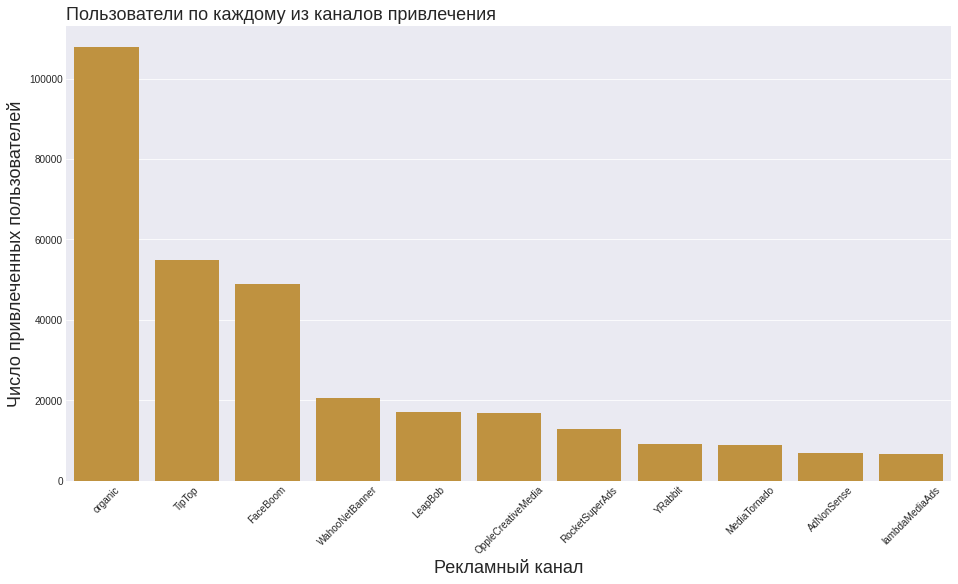

In [20]:
title = 'Пользователи по каждому из каналов привлечения'
xlabel = 'Рекламный канал'
ylabel = 'Число привлеченных пользователей'
data = channel_count.sort_values(by='user_id', ascending=False)
calc.sns_catplot(x='channel', y='user_id', data=data, title=title, xlabel=xlabel, ylabel=ylabel)

&#9889; **Вывод**

В датасете о посещениях сайта:

- сведения о 4 регионах, больше всего наблюдений о пользователях из США - 207327 из 309901 наблюдения (67%), больше всего пользовавшихся iPhone - 112603 из 309901 наблюдения (36%),
- более трети пользователей пришли напрямую - 107760 из 309901 (36%),
- самое раннее наблюдение о первом действии - 01.05.2019 года, самое позднее - 31.10.2019 года.

### - orders - информация о покупках

In [ ]:
calc.orders.describe(include=['float64']).T

In [ ]:
calc.orders.describe(include=['object', 'datetime64[ns]']).T

С учетом того, что 75%-процентиль - 4.99 (совпадающий с медианой, 25%-процентилем и минимуом), максимальная сумма выручки - 49.99, проверим какие значения выручки есть в датасете:

In [ ]:
sorted(calc.orders.revenue.unique())

Всего пять значений стоимости услуги. Проверим сколько пользователей платят больше 4.99, возможно, таких пользователей стоит рассматривать отдельно:

In [ ]:
max_revenue = calc.orders.groupby('revenue').agg({'user_id': 'count'}).reset_index()
max_revenue['%'] = (max_revenue['user_id'] / len(calc.orders)) * 100
max_revenue

Примерно 5% пользователей платят больше базовой стоимости. Посчитаем общее число таких пользователей:

In [ ]:
sum(max_revenue[max_revenue['revenue'] > 4.99]['user_id'])

&#9889; **Вывод**

В датасете с информацией о покупках:

- остутствуют сведения о валюте в которой выражена выручка,
- принимая во внимание, что 67% пользователей из США, можно предположить, что валюта выручки - доллары США,
- выявлено 5 различных стоимостей услуг - 4.99, 5.99, 9.99, 19.99, 49.99.
- минимальная сумма выручки - 4.99, средняя - 5.37 (при медианной и 75%-процентиле - 4.99), максимальная - 49.99,
- Из 40185 платящих пользователей - 1581 (4%) платит больше базового тарифа,
- самое раннее наблюдение о первом действии совпадает с датасетом о посещениях - 01.05.2019 года, самое позднее - 31.10.2019 года.

### - costs - информация о расходах

In [ ]:
calc.costs.describe().T

Минимально - 0.80, средняя стоимость источника - 58.61 (при медианой - 12.29 и 75%-процентиле равным 33.60). Есть очень дорогие источники. Проверим среднюю стоимость привлечения по каждому источнику: 

In [ ]:
channels_mean_costs = calc.costs.groupby('channel').agg({'costs': 'mean'}).reset_index()
channels_mean_costs.sort_values(by='costs')

In [ ]:
calc.costs.describe(include=['object', 'datetime64[ns]']).T

In [ ]:
calc.costs.groupby('channel').agg({'channel': 'count'})

&#9889; **Вывод:**

В датасете с информацией о покупках:

- всего десять каналов привлечения 
- самое раннее наблюдение о понесенных расходах - 01.05.2019 года, самое позднее - 27.10.2019 года.

&#9889; **Вывод:**
1. Описательная статистика неинформативна без точного описания данных без точного понимания, какие именно атрибуты наблюдений содержаться в столбцах f0, f1, f2.
2. В датасетах нет полных дубликатов.
3. В каждом из датасетов в столбце id есть повторяющиеся значения: df_geo_1 - 10 из 100 000 (0,0001‬%), df_geo_2 - 4 из 100 000 (0,00004%), df_geo_3 - 4 из 100 000 (0,00004%). Вероятно, из некторых скважин брали несколько замеров, скорее всего на разных глубинах.
4. Исходя из описания данных, столбец id кандидат на удаление, поскольку уникальный идентификатор месторождения - не универсальный признак.

[В оглавление](#TOC)

## Вывод<a class="anchor" id="1_conclusion"></a>

Исходя из представленных данных и описаний данных, можно сделать следующие выводы:
1. В датасетах представлены данные георазведки из трех регионов по 100 000 уникальных наблюдений в каждом.
2. Во всех датасетах нет проблем с типами данных, полные дубликаты отсутствуют, нет пропусков.
3. Есть повторяющиеся значения в столбцах с id: df_geo_1 - 10 из 100 000 (0,0001‬%), df_geo_2 - 4 из 100 000 (0,00004%), df_geo_3 - 4 из 100 000 (0,00004%). 
4. Поскольку нет возможности уточнить у источника данных - исходим из буквального описания датасета: есть наблюдения из одних тех же скважин. 
5. Столбец id не будет использован для обучения модели, поскольку является неуниверсальным атрибутом.

[В оглавление](#TOC)

In [ ]:
from calculator.calculator import MetricCalculator

In [ ]:
calc = MetricCalculator('datasets/visits_info_short.csv', 'datasets/orders_info_short.csv', 'datasets/costs_info_short.csv')

In [ ]:
calc.columns_fixer()

In [ ]:
observation_date = datetime(2019, 11, 1).date()
horizon_days = 30

In [ ]:
profiles = calc.get_profiles()

In [ ]:
profiles

In [ ]:
retention_raw, retention_grouped, retention_hist = calc.get_retention(profiles, observation_date, horizon_days)

In [ ]:
calc.plot_retention(retention_grouped, retention_hist, horizon_days)

In [ ]:
cr_raw, cr_grouped, cr_hist = calc.get_conversion(profiles, observation_date, horizon_days)

In [ ]:
calc.plot_conversion(cr_grouped, cr_hist, horizon_days)

In [ ]:
ltv_raw, ltv_grouped, ltv_hist, roi_grouped, roi_hist = calc.get_ltv(profiles, observation_date, horizon_days)

In [ ]:
calc.plot_ltv_roi(ltv_grouped, ltv_hist, roi_grouped, roi_hist, horizon_days) 

In [ ]:
ltv_raw, ltv_grouped, ltv_hist, roi_grouped, roi_hist = calc.get_ltv(profiles, observation_date, horizon_days, dimensions=['region'])

In [ ]:
calc.plot_ltv_roi(ltv_grouped, ltv_hist, roi_grouped, roi_hist, horizon_days, window=14) 

In [ ]:
ltv_raw, ltv_grouped, ltv_hist, roi_grouped, roi_hist = calc.get_ltv(profiles, observation_date, horizon_days, dimensions=['channel'])

In [ ]:
calc.plot_ltv_roi(ltv_grouped, ltv_hist, roi_grouped, roi_hist, horizon_days) 

In [ ]:
ltv_raw, ltv_grouped, ltv_hist, roi_grouped, roi_hist = calc.get_ltv(profiles, observation_date, horizon_days, dimensions=['payer'])

In [ ]:
calc.plot_ltv_roi(ltv_grouped, ltv_hist, roi_grouped, roi_hist, horizon_days) 

In [ ]:
profiles

In [ ]:
roi_hist

In [ ]:
cac_hist = roi_hist[['cac']]

In [ ]:
columns = [name for name in cac_hist.index.names if name not in ['dt']]

In [ ]:
filtered_data = cac_hist.pivot_table(index='dt', columns=columns, values='cac', aggfunc='mean')

In [ ]:
filtered_data

In [ ]:
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [ ]:
filtered_data.plot()

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
filter_data(filtered_data, 14).plot()
plt.axhline(y=1, color='red', linestyle='--',
            label='Уровень окупаемости')

In [ ]:
roi_grouped

In [ ]:
from datetime import datetime